In [1]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import seaborn as sns
import cell2location
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

/home/wzhang/miniconda3/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/wzhang/miniconda3/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


# Download the spatial data, then run this script using R 

In [ ]:
library(Seurat)
library(SeuratData)
library(SeuratDisk)
library(ggplot2)
library(patchwork)
library(dplyr)
library(spacexr)
library(optparse)

root_dir <- './data/GSE210616/'
sample_id <- 'GSM6433590_093D'
ISG_file <- './ISGgene.txt'
target_gene <- 'ENPP1'

sample_path <- paste0(root_dir, '/', sample_id) 
cmd1 <- paste0("mkdir -p ", sample_path)
t1 <- try(system(cmd1, intern=TRUE)) 
if(!identical(t1, character(0))){
    stop("Error: ", t1)
}

cmd2 <- paste0("mkdir -p ", sample_path, '/spatial')
t2 <- try(system(cmd2, intern=TRUE)) 
if(!identical(t2, character(0))){
    stop("Error: ", t2)
}

scale_file <- paste0(root_dir, '/',sample_id, '_scalefactors_json.json')
image_file <- paste0(root_dir, '/',sample_id, '_tissue_hires_image.png')
position_file <- paste0(root_dir, '/',sample_id, '_tissue_positions_list.csv')
feature_file <- paste0(root_dir, '/',sample_id, '_filtered_feature_bc_matrix.h5')

if (file.exists(scale_file)) {
    print("The scale file exists!")
    cmd3 <- paste0('cp ', scale_file, ' ', sample_path, '/spatial/scalefactors_json.json')
    t3 <- try(system(cmd3, intern=TRUE)) 
    if(!identical(t3, character(0))){
        stop("Error: ", t3)}
    } else {
  print("The scale file does not exist.")
}

if (file.exists(image_file)) {
    print("The image file exists!")
    cmd <- paste0('cp ', image_file, ' ', sample_path, '/spatial/tissue_hires_image.png')
    t <- try(system(cmd, intern=TRUE)) 
    if(!identical(t, character(0))){
        stop("Error: ", t) }

    cmd <- paste0('cp ', image_file, ' ', sample_path, '/spatial/tissue_lowres_image.png')
    t <- try(system(cmd, intern=TRUE)) 
    if(!identical(t, character(0))){
        stop("Error: ", t)}
} else {
    print("The image file does not exist.")
}

if (file.exists(position_file)) {
    print("The position file exists!")
    cmd <- paste0('cp ', position_file, ' ', sample_path, '/spatial/tissue_positions_list.csv')
    t <- try(system(cmd, intern=TRUE)) 
    if(!identical(t, character(0))){
        stop("Error: ", t)}
} else {
    print("The position file does not exist.")
}

if (file.exists(feature_file)) {
    print("The feature file exists!")
    
} else {
    print("The feature file does not exist.")
}

# Load image ST data using Load10X_Spatial from Seurat
sample_1_image <- Read10X_Image(
    paste0(sample_path, '/spatial/'),
    image.name = 'tissue_hires_image.png',
    filter.matrix = TRUE
)
sample_1_image@scale.factors
dim(sample_1_image@image)
sample_1_image@coordinates[1:10,1:3]

sample_1 <- Load10X_Spatial(
  root_dir,
  filename = paste0(sample_id, '_filtered_feature_bc_matrix.h5'),
  image = sample_1_image,
  filter.matrix = TRUE, 
  to.upper = FALSE
)

sample_1@assays
dim(sample_1@meta.data)
print(head(sample_1@meta.data))
# save raw data to h5ad file 
SaveH5Seurat(sample_1, filename = paste0(sample_path, '/',"sample_raw.h5Seurat"))
Convert(paste0(sample_path, '/','sample_raw.h5Seurat'), dest = "h5ad")

# QC
sample_1[["percent.mt"]] <- PercentageFeatureSet(sample_1, pattern = "^mt-")
# normalize the data
sample_1_norm <- SCTransform(sample_1, assay = "Spatial", verbose = FALSE,
residual.features = rownames(sample_1@assays$Spatial))
print(dim(sample_1_norm@assays$SCT@counts))
print(dim(sample_1_norm@assays$SCT@scale.data))

sample_obj <- RunPCA(sample_1_norm, assay = "SCT", verbose = FALSE)
# compute K nearest neighbors (KNN)
sample_obj <- FindNeighbors(sample_obj, reduction = "pca", dims = 1:30)
# Leiden algorithm for community detection
sample_obj <- FindClusters(sample_obj, verbose = FALSE)
# PCA result is the default UMAP input, use dimensions 1:30 as input features
sample_obj <- RunUMAP(sample_obj, reduction = "pca", dims = 1:30)

# analysis
# find variable features 
variable_features <- VariableFeatures(sample_obj)
print(paste("Number of variable features:", length(variable_features)))

ISG <- read.table(ISG_file,head=F)
ISG <- unique(ISG$V1)

moran_features <- intersect(variable_features, c(target_gene, ISG))

# calculate moransi for each gene selected 
sample_moransi <- FindSpatiallyVariableFeatures(
    sample_obj, assay = "SCT", 
    features = moran_features,
    selection.method = "moransi") 

moransi_output_df <- sample_moransi@assays$SCT@meta.features %>% na.exclude
print(paste("Number of moransi features:", dim(moransi_output_df)[1]))

# save moransi result to csv file
write.csv(moransi_output_df, file = paste0(sample_path, '/','moransi_output.csv'), row.names = T) 
# save sample data to rds file
saveRDS(sample_moransi, file = paste0(sample_path, '/','sample_moransi.rds'))

# run this script using R for RCTD

In [ ]:
library(Seurat)
library(SeuratData)
library(SeuratDisk)
library(ggplot2)
library(patchwork)
library(dplyr)
library(spacexr)
library(optparse)
 
root_dir <- './data/GSE210616/'
sample_id <- 'GSM6433611_120D'
ref_file <-  './data/GSE176078/scRNA.allTNBC.naive.rds') 

# prepare the reference
ref <- readRDS(ref_file)
## remove cell type with less than 25 cells
min_cells <- 25 
cells_per_type <- as.data.frame(table(ref@meta.data$celltype_minor))
cells_per_type$Var1 <- as.character(cells_per_type$Var1)
cells_to_remove <- cells_per_type[cells_per_type$Freq <= min_cells,]$Var1
cells_to_remove 
ref <- subset(ref, subset = celltype_minor %in% cells_to_remove, invert = TRUE)
# as.data.frame(table(ref@meta.data$celltype_minor))

ref <- UpdateSeuratObject(ref)
Idents(ref) <- "celltype_minor"
counts <- GetAssayData(object = ref, slot = 'counts')
cluster <- as.factor(ref$celltype_minor)
names(cluster) <- colnames(ref)
nUMI <- ref$nCount_RNA
names(nUMI) <- colnames(ref)
reference <- Reference(counts, cluster, nUMI, n_max_cells = 20000)

# prepare the query 
sample_obj <- readRDS(paste0(paste(root_dir, sample_id, sep = '/'), '/','sample_moransi.rds')) 
counts <- GetAssayData(object = sample_obj, slot = 'counts')
coords <- GetTissueCoordinates(sample_obj)
colnames(coords) <- c("x", "y")
coords[is.na(colnames(coords))] <- NULL
query <- SpatialRNA(coords, counts, colSums(counts))

# run RCTD 
RCTD <- create.RCTD(query, reference, max_cores = 8)
RCTD <- run.RCTD(RCTD, doublet_mode = "full") # doublet_mode can be "singlet", "doublet", "multi" or "full"
saveRDS(RCTD, file = paste0(paste(root_dir, sample_id, sep = '/'), '/','sample_rctd.rds'))

rctd_metadata <- RCTD@results[['weights']]
rctd_metadata <- normalize_weights(rctd_metadata) 
write.csv(rctd_metadata, paste0(paste(root_dir, sample_id, sep = '/'), '/','rctd_weights.csv'), row.names = T)

# visualize the rctd results
rctd_metadata_sparce <- as.data.frame(rctd_metadata)
rctd_metadata_sparce[rctd_metadata_sparce < 0.05] <- 0

cell_type_distribution <- as.data.frame(rctd_metadata_sparce) %>% summarise(across(everything(), ~sum(.x > 0)))
cell_type_distribution <- as.data.frame(t(cell_type_distribution))
colnames(cell_type_distribution) <- 'cell_type_count'
cell_type_distribution$cell_type_subset <- rownames(cell_type_distribution)
cell_type_distribution <- cell_type_distribution[order(cell_type_distribution$cell_type_count, decreasing = T), ]
cell_type_distribution$cell_type_subset <- factor(cell_type_distribution$cell_type_subset, 
levels=unique(cell_type_distribution$cell_type_subset))

count_distribution <- as.data.frame(apply(rctd_metadata_sparce, 1,function(x) sum(x > 0)))
colnames(count_distribution) <- 'cell_type_count'
count_distribution$cell_type_count <- as.numeric(count_distribution$cell_type_count)

# ggplot histogram
plot2 <- ggplot(count_distribution, aes(x = cell_type_count)) + geom_histogram(binwidth = 0.05)
ggsave(plot2, filename = paste0(root_dir, '/', sample_id, '/',
"rctd_cell_type_count_distribution.png"), width = 6, height = 6, dpi = 300)
plot3 <- ggplot(cell_type_distribution, aes(x = cell_type_subset, y = cell_type_count, 
fill = cell_type_subset)) + 
  geom_col() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
ggsave(plot3, filename = paste0(root_dir, '/', sample_id, '/',
"rctd_cell_type_by_spot_distribution.png"), width = 10, height = 8, dpi = 300)

SaveH5Seurat(RCTD, filename = "./data/adata_rctd")
Convert("./data/adata_rctd.h5seurat", dest = "h5ad")


# Plot

In [2]:
# defining useful function
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

def compute_spot_size(adata, gene_symbol, size):
    r""" returns a vector with the size of the spots. Areas where no expression is observed for a given
    gene are set to size zero.
    
    :param adata: Anndata object
    :param gene_symbol: Gene Symbol for whom we explore gene expression
    :param size: size for the spots when their expression is different from zero.
    """
    index=adata.var[adata.var["SYMBOL"]== gene_symbol].index.values[0]
    expression_values = adata.X.todense()[:,adata.var.index.get_loc(index)]
    for x in range(len(expression_values)):
        if expression_values[x] > 0:
            expression_values[x] = size
        else:
            expression_values[x] = 0
    
    
    return expression_values.tolist()

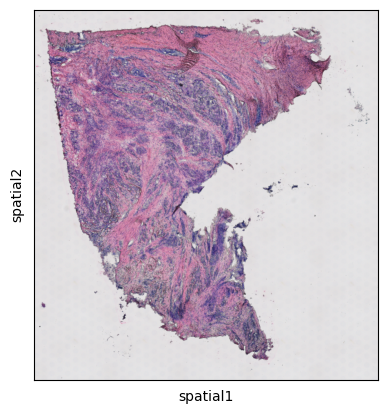

AnnData object with n_obs × n_vars = 661 × 16121
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'B.cells.Memory', 'B.cells.Naive', 'CAFs.MSC.iCAF.like', 'CAFs.myCAF.like', 'Cancer.Basal.SC', 'Cancer.Cycling', 'Cancer.Her2.SC', 'Cancer.LumA.SC', 'Cancer.LumB.SC', 'Cycling.T.cells', 'Cycling_Myeloid', 'DCs', 'Endothelial.ACKR1', 'Endothelial.CXCL12', 'Endothelial.Lymphatic.LYVE1', 'Endothelial.RGS5', 'Luminal.Progenitors', 'Macrophage', 'Mature.Luminal', 'Monocyte', 'Myoepithelial', 'NK.cells', 'NKT.cells', 'PVL.Differentiated', 'PVL.Immature', 'Plasmablasts', 'T.cells.CD4.', 'T.cells.CD8.', 'ISG_score'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts

In [3]:
import pandas as pd
Genes = pd.read_table('./ISGgene.txt', header = None)
gene_list = Genes[0].tolist()
Prefix = 'GSM6433591_094A'

InputDir = './data/' + Prefix + '/'
adata_vis = sc.read_h5ad(InputDir + 'adata_rctd.h5ad')
adata_vis.var_names_make_unique()
sc.pl.spatial(adata_vis, img_key="hires")
adata_vis


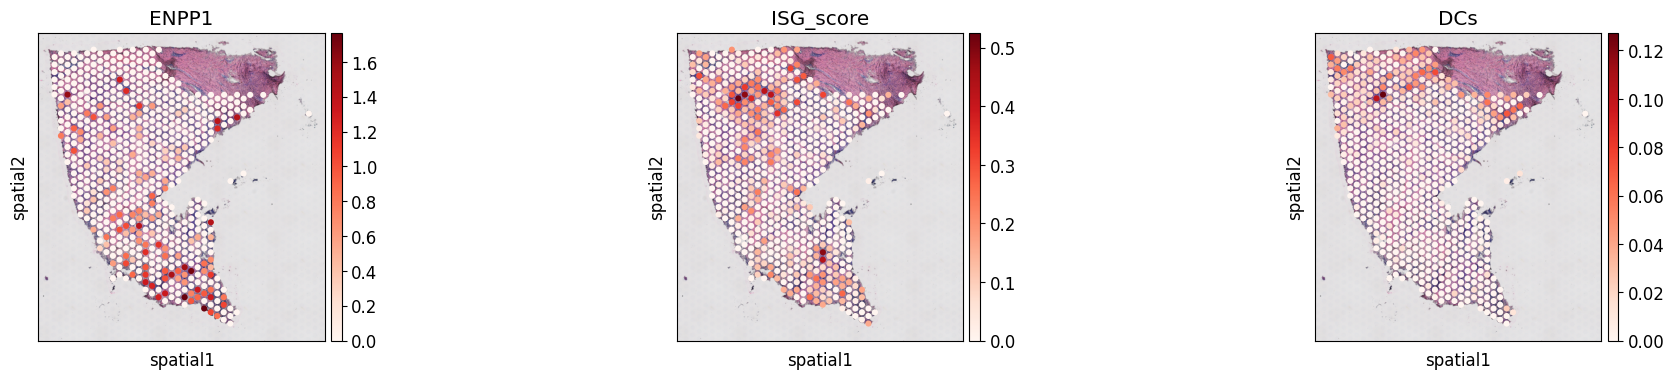

In [10]:
slide = adata_vis.copy()
Targets = ['ENPP1', 'ISG_score', 'DCs']
with mpl.rc_context({'figure.figsize': (8,4), "font.size": 12}):
    sc.pl.spatial(slide, color=Targets, size=1.25, color_map = "Reds", use_raw=False, alpha_img = 1, 
                  ncols=4, hspace=0.2, wspace=0.001, vmin = 0)
    


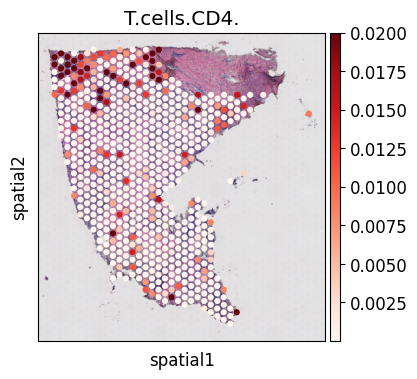

In [7]:
Targets = ['T.cells.CD4.']
with mpl.rc_context({'figure.figsize': (6,4), "font.size": 12}):
    sc.pl.spatial(slide, color=Targets, size=1.25, color_map = "Reds", use_raw=False, alpha_img = 1, 
                  ncols=3, hspace=0.2, wspace=0.1, vmax = 0.02)